In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(18712, 28)
(18712, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, 21] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging.shape

(9364, 28)

In [9]:
Y_motion_FL_swinging.shape

(9364, 4)

In [10]:
X_motion_FL_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.63652642e-02,
       -1.83961355e-03,  2.59306532e-03,  2.54300085e-04,  6.98410068e-04,
        1.33650489e-03,  1.06813557e+02,  4.61969252e-02,  2.64308418e-02,
        1.06808456e+02, -1.92503579e-01,  2.64288159e-02,  1.06328093e+02,
        8.61793880e-02,  2.64343539e-02,  1.06331439e+02, -1.50907082e-01,
        2.64325988e-02,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [11]:
Y_motion_FL_swinging[0, :]

array([-0.00828009,  0.04045801, -0.00636973, -0.04229659])

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9766291634172473
RMSE:  0.012491929380407371
The lowest error is:  6.930017232842367e-07
The highest error is:  0.04533717634904916
The avg. error is:  0.009109743732203439


In [13]:
model_fl_relative_support_x.coef_

array([[-0.04492919, -0.02060393, -0.02695808,  0.21206948,  0.01437984,
        -0.00696759, -0.27434622,  0.15721953,  0.32120999, -0.02254601,
         0.47832031, -0.21778009, -0.52518629,  0.08302056]])

In [14]:
model_fl_relative_support_x.intercept_

array([-0.00645457])

Text(0, 0.5, 'Predictions')

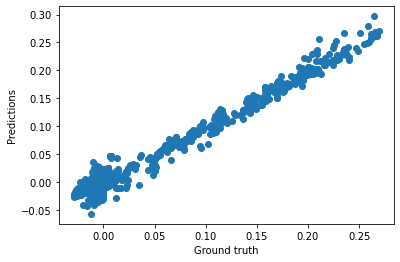

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [16]:
#%store model_fl_relative_support_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [19]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9115712964020962
RMSE:  0.013421649079670379
The lowest error is:  3.472523984604514e-05
The highest error is:  0.10035469013883605
The avg. error is:  0.009846407947241032


In [20]:
model_fl_relative_support_y.coef_

array([[ 0.00280545, -0.02679292,  0.03154742,  0.02627906,  0.21185638,
         0.01483404, -0.08972539, -0.28939497, -0.00880658,  0.29043648,
         0.09789753,  0.42591386,  0.00062771, -0.42712738]])

In [21]:
model_fl_relative_support_y.intercept_

array([-0.00152897])

Text(0, 0.5, 'Predictions')

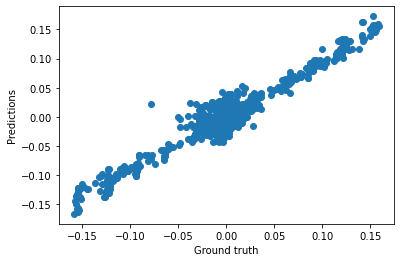

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [23]:
#%store model_fl_relative_support_y

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [25]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")